#Solving QUBOs with DWAVE Simulated Annealing

Date: December 4th, 2023

The notebook contains materials supporting the tutorial paper:
*Five Starter Problems: Solving QUBOs on Quantum Computers* by Arul Rhik Mazumder (arulm@andrew.cmu.edu) and Sridhar Tayur (stayur@cmu.edu).
It depends on various packages shown below.

### **Introduction**


Simulated Annealing is a widely used probabilistic optimization algorithm that is used to find the global minimum or maximum of a complex, multivariate objective function. It is often employed in optimization problems where an exhaustive search of the entire solution space is not feasible due to its size or computational cost.

The algorithm is inspired by the annealing process in metallurgy, where a material is heated and then gradually cooled to remove defects and optimize its structure. In a similar fashion, simulated annealing iteratively explores the solution space in search of the optimal solution, while allowing for occasional uphill moves (accepting worse solutions) to escape local minima or maxima. Over time, the likelihood of accepting worse solutions decreases, simulating the annealing process.

DWAVE Ocean offers a Simulated Annealing Sampler that can be used to solve approprate QUBOs using Simulated Annealing. Further details about this utility can be found below:

https://docs.ocean.dwavesys.com/projects/neal/en/latest/reference/sampler.html

In [363]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  !pip install -q dwave-ocean-sdk==6.10.0
  !pip install -q bravado==11.0.3
  !pip install -q pyqubo==1.4.0
  print("All Packages Installed!")

All Packages Installed!


In [364]:
# imports necessary packages to run on a DWAVE Machine
from pyqubo import Spin, Array, Placeholder, Constraint
import matplotlib.pyplot as plt
import networkx as nx
import dimod
import neal

# Misc. imports
import numpy as np
import random
import time
import os

# Connecting to DWAVE Account
os.environ['DWAVE_API_TOKEN'] = 'DEV-7aecbd09552afc1cb9cba26c01212e6224025c2c'

### **Example 1 - Number Partitioning Problem**

Initializing an arbitrary number partitioning instance.

In [365]:
test_1 = [1, 5, 11, 5]
test_2 = [25, 7, 13, 31, 42, 17, 21, 10]
arr = test_2
print(arr)
n = len(arr)
c = sum(arr)

[25, 7, 13, 31, 42, 17, 21, 10]


**Number Partitioning Models**

Given an array of $n$ integers $[a_{1}, a_{2}, a_{3} ... a_{n}]$, the corresponding Ising Hamiltonian is:

$$H=(\sum_{i=1}^{n}a_{i}s_{i})^2$$

Where $s_{i} \in \{-1,1\}$ is the Ising spin variable.

Similarly the corresponding QUBO Model is:

$$Q=(\sum_{i=1}^{n}a_{i}-2\sum_{i=1}^{n}a_{i}x_{i})^{2}$$
or
$$Q=(c-2\sum_{i=1}^{n}a_{i}x_{i})^{2}$$

Where $c=\sum_{i=1}^{n}a_{i}$ and $x_{i} \in \{0, 1\}$ is a binary quadratic variable.

In [366]:
x = Array.create('x', n, 'BINARY')
H = (c - 2*sum(arr[i]*x[i] for i in range(n)))**2
model = H.compile()
bqm = model.to_bqm()

Running the problem on the the DWAVE Simulated Annealing Sampler

In [367]:
sa = neal.SimulatedAnnealingSampler()
start_time = time.time()
sampleset = sa.sample(bqm, num_reads=1000)
end_time = time.time()
elapsed_time = end_time - start_time
decoded_samples = model.decode_sampleset(sampleset)
sample = min(decoded_samples, key=lambda x: x.energy)

In [368]:
# Converting the output binary variables to produce a valid output
def NPP_measure(sortedSample):
  P1 = []
  P2 = []
  for i in sortedSample.keys():
    if sortedSample[i] == 0:
        P1.append(arr[int(i[2:len(i)-1])])
    else:
        P2.append(arr[int(i[2:len(i)-1])])
  sum1 = sum(P1[i] for i in range(len(P1)))
  sum2 = sum(P2[i] for i in range(len(P2)))
  print(P1)
  print('Sum: ' + str(sum1))
  print(P2)
  print('Sum: ' + str(sum2))
  return abs(sum2-sum1)

In [369]:
#Sorts samples by numbers to see which quadratic variables are 0 and 1
sampleKeys = list(sample.sample.keys())
def sortbynumber(str):
    return int(str[2:len(str)-1])
sampleKeys.sort(key = sortbynumber)
sortedSample = {i: sample.sample[i] for i in sampleKeys}
print("Execution Time: " + str(elapsed_time))
NPP_measure(sortedSample)

Execution Time: 0.20899653434753418
[25, 7, 13, 17, 21]
Sum: 83
[31, 42, 10]
Sum: 83


0

### **Example 2 - Max-Cut**

Initializing an arbitrary Max-Cut instance.

In [370]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes()
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")

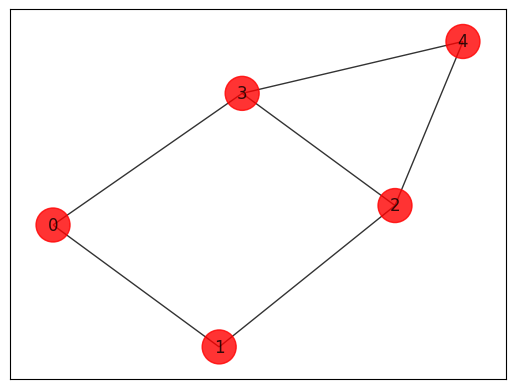

In [371]:
# Generating a graph of 4 nodes

n = 5 # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
edges = [(0, 1, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0), (2, 4, 1.0), (3, 4, 1.0)]
G.add_weighted_edges_from(edges)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)

draw_graph(G, colors, pos)

**Max-Cut Models**

Given an undirected unweighted Graph $G$ with vertex set $V$ and edge set $E$ with edges $(i, j)$ the corresponding Ising Hamiltonian is:

$$H=\sum_{(i, j) \in E}\frac{1-s_{i}s_{j}}{2}$$

Where $s_{i} \in \{-1,1\}$ is the Ising spin variable.

The corresponding QUBO Model is:

$$Q=\sum_{(i, j)\in E}(x_{i}+x_{j}-2x_{i}x_{j})$$

Where $x_{i} \in \{0, 1\}$ is a binary quadratic variable.

In [372]:
x = Array.create('x', n, 'BINARY')
H = sum(2*x[e[0]]*x[e[1]] - x[e[0]] - x[e[1]] for e in edges)
model = H.compile()
bqm = model.to_bqm()

Running the problem on the the DWAVE Simulated Annealing Sampler

In [373]:
sa = neal.SimulatedAnnealingSampler()
start_time = time.time()
sampleset = sa.sample(bqm, num_reads=1000)
end_time = time.time()
elapsed_time = end_time - start_time
decoded_samples = model.decode_sampleset(sampleset)
sample = min(decoded_samples, key=lambda x: x.energy)

In [374]:
#Sorts samples by numbers to see which quadratic variables are 0 and 1
sampleKeys = list(sample.sample.keys())
def sortbynumber(str):
    return int(str[2:len(str)-1])
sampleKeys.sort(key = sortbynumber)
sortedSample = {i: sample.sample[i] for i in sampleKeys}
print(sortedSample)

{'x[0]': 0, 'x[1]': 1, 'x[2]': 0, 'x[3]': 1, 'x[4]': 0}


In [375]:
# Converting the output binary variables to produce a valid output
def MaxCut(sortedSample):
  maxcut_sol = []
  for i in sortedSample.keys():
    if sortedSample[i] == 0:
        maxcut_sol.append(0)
    else:
        maxcut_sol.append(1)
  colors = ["r" if maxcut_sol[i] == 0 else "c" for i in range(len(maxcut_sol))]
  draw_graph(G, colors, pos)
  cutsize = 0
  for u, v in G.edges():
    if maxcut_sol[u] != maxcut_sol[v]:
      cutsize += 1
  return cutsize

Execution Time: 0.0999906063079834
5


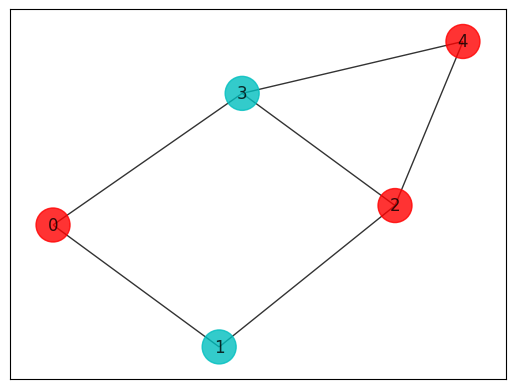

In [376]:
print("Execution Time: " + str(elapsed_time))
print(MaxCut(sortedSample))

### **Example 3 - Minimum Vertex Cover**

Initializing an arbitrary Minimum Vertex Cover instance.

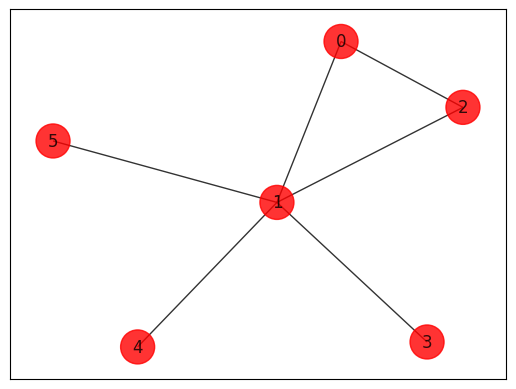

In [377]:
# Generating a graph of 4 nodes

n = 6  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
edges = [(0, 1, 1.0), (0, 2, 1.0), (1, 2, 1.0), (1, 3, 1.0), (1, 4, 1.0), (1, 5, 1.0)]
G.add_weighted_edges_from(edges)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)

draw_graph(G, colors, pos)

**Minimum Vertex Cover Models**

Given an undirected unweighted Graph $G$ with vertex set $V$ with vertices $i$ and edge set $E$ with edges $(i, j)$ the corresponding Ising Hamiltonian is:

$$H=P\sum_{(i, j) \in E}(1-s_{i})(1-s_{j}) + \sum_{i \in V}s_{i}$$

Where $s_{i} \in \{-1,1\}$ is the Ising spin variable and $P$ is the penalty coefficient.

The corresponding QUBO Model is:

$$Q=\sum_{i \in V}x_{i} + P(\sum_{(i, j) \in E}(1-x_{i}-x_{j}+x_{i}x_{j}))$$

Where $x_{i} \in \{0, 1\}$ is a binary quadratic variable.

Note in the example $P$ was chosen through trial-and-error although there exists rigorous mathematical processes

In [378]:
x = Array.create('x', n, 'BINARY')
P = 0.5
H = sum(x[i] for i in range(n)) + P*sum(1 - x[e[0]] - x[e[1]] + x[e[0]]*x[e[1]] for e in edges)
model = H.compile()
bqm = model.to_bqm()

Running the problem on a DWAVE Simulated Annealing Sampler.

In [379]:
sa = neal.SimulatedAnnealingSampler()
start_time = time.time()
sampleset = sa.sample(bqm, num_reads=1000)
end_time = time.time()
elapsed_time = end_time - start_time
decoded_samples = model.decode_sampleset(sampleset)
sample = min(decoded_samples, key=lambda x: x.energy)

In [380]:
#Sorts samples by numbers to see which quadratic variables are 0 and 1
sampleKeys = list(sample.sample.keys())
def sortbynumber(str):
    return int(str[2:len(str)-1])
sampleKeys.sort(key = sortbynumber)
sortedSample = {i: sample.sample[i] for i in sampleKeys}
print(sortedSample)

{'x[0]': 0, 'x[1]': 1, 'x[2]': 0, 'x[3]': 0, 'x[4]': 0, 'x[5]': 0}


In [381]:
# Converting the output binary variables to produce a valid output
def MVC(sortedSample):
  mvc_sol = []
  for i in sortedSample.keys():
    if sortedSample[i] == 0:
        mvc_sol.append(0)
    else:
        mvc_sol.append(1)
  colors = ["r" if mvc_sol[i] == 0 else "c" for i in range(len(mvc_sol))]
  draw_graph(G, colors, pos)
  covered = 0
  for u, v in G.edges():
    if mvc_sol[u] == 1 or mvc_sol[v] == 1:
      covered += 1
  return covered

Execution Time: 0.16471481323242188
5


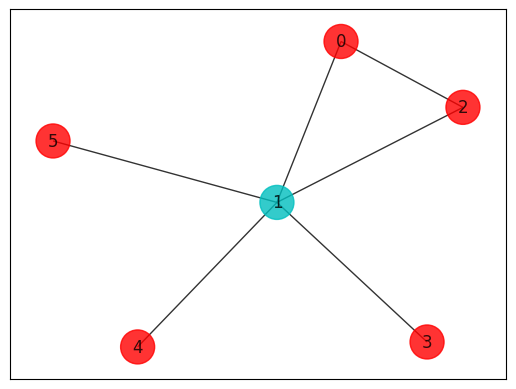

In [382]:
print("Execution Time: " + str(elapsed_time))
print(MVC(sortedSample))

### **Example 4 - Cancer Genomics**



Identifying Cancer Gene Pathways from the TCGA-AML Data. The techniques used were taken from: https://www.biorxiv.org/content/10.1101/845719v1

In [383]:
# import necessary package for data imports
from bravado.client import SwaggerClient

Accessing AML study data from the cbioportal.

In [384]:
# connects to cbioportal to access data
#info here https://github.com/mskcc/cbsp-hackathon/blob/master/0-introduction/cbsp_hackathon.ipynb
cbioportal = SwaggerClient.from_url('https://www.cbioportal.org/api/v2/api-docs',
                                config={"validate_requests":False,"validate_responses":False,"validate_swagger_spec":False})

In [385]:
# connects to cbioportal to access data
#info here https://github.com/mskcc/cbsp-hackathon/blob/master/0-introduction/cbsp_hackathon.ipynb
cbioportal = SwaggerClient.from_url('https://www.cbioportal.org/api/v2/api-docs',
                                config={"validate_requests":False,"validate_responses":False,"validate_swagger_spec":False})

# access the patient data of AML study
patients = cbioportal.Patients.getAllPatientsInStudyUsingGET(studyId='laml_tcga').result()

# for each mutation, creates a list of properties associated with the mutation include geneID, patientID, and more
InitialMutations = cbioportal.Mutations.getMutationsInMolecularProfileBySampleListIdUsingGET(
    molecularProfileId='laml_tcga_mutations',
    sampleListId='laml_tcga_all',
    projection='DETAILED'
).result()

Identifying the $33$ most common genes from the study.

Then preprocessing the data to create a Patient-Gene Dictionary to construct the matrices from.

In [386]:
# tests if data is correct
# Compares the frequency of the 33 most common genes and compares them with the information listed on
# https://www.cbioportal.org/study/summary?id=laml_tcga
from collections import Counter
mutation_counts = Counter([m.gene.hugoGeneSymbol for m in InitialMutations])
MostImportantMutationsCounts = mutation_counts.most_common(33)
MostImportantMutations = []
for i in range(len(MostImportantMutationsCounts)):
    MostImportantMutations.append(MostImportantMutationsCounts[i][0])

In [387]:
# Adds mutations including 33 most frequent genes to a mutations list
mutations = []
for m in InitialMutations:
    if m.gene.hugoGeneSymbol in MostImportantMutations:
        mutations.append(m)

In [388]:
# Creates a gene set also for later use (can also be utilized to count the number of genes)
geneset = set()
for m in mutations:
    geneset.add(m.gene.hugoGeneSymbol)

In [389]:
# creates a patient-(gene-list) dictionary
PatientGeneDict = {}
# first sort the patients by index
def sortPatients(m):
    return m.patientId
mutations.sort(key = sortPatients)
#print(mutations)
# iterates through the mutation list
for m in mutations:
    if m.patientId in PatientGeneDict.keys(): # if the patient is already in dictionary add the gene to their previous gene list
        PatientGeneDict[m.patientId].append(m.gene.hugoGeneSymbol)
    else:
        PatientGeneDict[m.patientId] = [m.gene.hugoGeneSymbol] # else add the patient their associated gene

In [390]:
# create independent patient and gene lists
patientset = set()
for m in mutations:
    patientset.add(m.patientId)
patientList = [] # patient list
for m in patientset:
    patientList.append(m)
geneList = [] # gene list
for gene in geneset:
    geneList.append(gene)
geneList.sort()

Patient-Gene Dictionary that displays each patient and their corresponding gene-list.

In [391]:
# Organized way to visualize the patient-(gene-list) dictionary
print("Patient-Gene Dictionary:")
for k in PatientGeneDict.keys():
    print(k)
    print(PatientGeneDict[k])

Patient-Gene Dictionary:
TCGA-AB-2802
['DNMT3A', 'IDH1', 'MT-ND5', 'NPM1', 'NPM1', 'PTPN11']
TCGA-AB-2804
['PHF6']
TCGA-AB-2805
['RUNX1', 'RUNX1', 'IDH2']
TCGA-AB-2806
['PLCE1']
TCGA-AB-2807
['RUNX1', 'IDH2', 'ASXL1']
TCGA-AB-2808
['CEBPA', 'NRAS']
TCGA-AB-2809
['DNMT3A', 'NPM1']
TCGA-AB-2810
['IDH2', 'NPM1']
TCGA-AB-2811
['DNMT3A', 'FLT3', 'NPM1', 'SMC1A']
TCGA-AB-2812
['FLT3', 'NPM1']
TCGA-AB-2813
['CACNA1B', 'TP53']
TCGA-AB-2814
['CACNA1B', 'FLT3', 'MT-CO2']
TCGA-AB-2816
['DNMT3A', 'FLT3', 'NPM1', 'NRAS']
TCGA-AB-2817
['EZH2', 'EZH2', 'MT-ND5', 'BRINP3']
TCGA-AB-2818
['DNMT3A', 'FLT3', 'NPM1', 'RAD21']
TCGA-AB-2819
['KIT']
TCGA-AB-2820
['MT-CO2', 'TP53']
TCGA-AB-2821
['RUNX1', 'IDH1', 'IDH2', 'U2AF1', 'ASXL1']
TCGA-AB-2822
['DNMT3A', 'IDH1', 'SMC1A', 'TET2']
TCGA-AB-2824
['DNMT3A', 'NPM1', 'SMC1A']
TCGA-AB-2825
['DNMT3A', 'FLT3', 'NPM1']
TCGA-AB-2826
['IDH2', 'KRAS', 'NPM1']
TCGA-AB-2829
['TP53', 'TP53']
TCGA-AB-2830
['DNMT3A', 'FLT3', 'TET2', 'TET2']
TCGA-AB-2831
['DNMT3A']
TCGA-AB

Create the diagonal $\mathbf{D}$ matrix to represent gene-coverage.

In [392]:
import numpy as np
D = np.zeros((n, n))
for i in range(n):
    count = 0
    for k in PatientGeneDict.keys():
        if geneList[i] in PatientGeneDict[k]:
            count += 1
        D[i][i] = count

Generate gene pairs to create the $\mathbf{A}$ exclusivity matrix

In [393]:
from itertools import combinations

def generate_power_sets(lst):
    power_sets = set()
    for subset in combinations(lst, 2):
        power_sets.add(tuple(sorted(subset)))
    return power_sets

Using the patient-gene dictionary, we identify all gene-pairs for each patient. This used to create the $\mathbf{A}$ matrix.

In [394]:
for key in PatientGeneDict:
    PatientGeneDict[key] = list(set(PatientGeneDict[key]))
# creates a patient-(gene-list-pair) dictionary
PatientGeneDictPairs = {}
for m in mutations:
        PatientGeneDictPairs[m.patientId] = generate_power_sets(PatientGeneDict[m.patientId])

With all the preprocessing done, the $\mathbf{A}$ matrix is completed.

In [395]:
# creates the A exclusivity matrix
A = np.zeros((n, n))
for j in range(n):
    if i != j:
        count = 0
        for k in PatientGeneDict.keys():
            if (geneList[i], geneList[j]) in PatientGeneDictPairs[k]:
                count += 1
        A[i][j] = count
        A[j][i] = count

Identify properties from the gene pathway:

In [396]:
# returns the coverage of a gene
def gene_coverage(gene):
    return D[geneList.index(gene)][geneList.index(gene)]

In [397]:
# returns the coverage of a pathway
def coverage(pathway):
    coverage_val = 0
    for i in pathway:
        coverage_val += gene_coverage(i)
    return coverage_val

In [398]:
# returns the indepence(exclusivity) of a pathway
def indep(pathway):
    num_overlap = 0
    for i in pathway:
        for j in pathway:
            if i == j:
                pass
            else:
                num_overlap += A[geneList.index(i)][geneList.index(j)]
    return num_overlap

Using the $\mathbf{A}$ and $\mathbf{D}$ matrices, we create the QUBO to identify the Cancer Genes. As stated in "Quantum and Quantum-inspired Methods for de novo
Discovery of Altered Cancer Pathways", the QUBO formulation to identify the cancer gene set while balancing Indepence and Coverage is:

$$\mathbf{Q}=\mathbf{x}^{T}(\mathbf{A}-\alpha \mathbf{D})\mathbf{x}$$

Where $\mathbf{D}$ and $\mathbf{A}$ are the previously found matrices and $\mathbf{x}$ is the vector of binary variables $x_{i}$

In [399]:
# initializes an array of QUBO variables
x = Array.create('x', n, 'BINARY')
H1 = sum(sum(A[i][j]*x[i]*x[j] for j in range(n)) for i in range(n))
H2 = sum(D[i][i]*x[i] for i in range(n))
a = Placeholder("alpha")
H = H1 - a*H2

Embedding and solving the problem on a DWAVE Simulated Annealer Sampler.

In [400]:
# Generate QUBO
model = H.compile()
feed_dict = {'alpha': 0.45}
bqm = model.to_bqm(feed_dict=feed_dict)

Get sampler solving details.

In [401]:
# Getting Results from Sampler
start_time = time.time()
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=10)
decoded_samples = model.decode_sampleset(sampleset, feed_dict=feed_dict)
sample = min(decoded_samples, key=lambda x: x.energy)
end_time = time.time()
total_time = end_time-start_time

In [402]:
#Sorts samples by numbers to see which quadratic variables are 0 and 1
sampleKeys = list(sample.sample.keys())
def sortbynumber(str):
    return int(str[2:len(str)-1])
sampleKeys.sort(key = sortbynumber)
sortedSample = {i: sample.sample[i] for i in sampleKeys}

Print the identified pathway.

In [403]:
# converts quadratic variables back to genes and computes coverage, coverage/gene, independence, and measure as mentioned in CMU paper
pathway = []
for i in sampleKeys:
    if sortedSample[i] == 1:
        pathway.append(geneList[int(i[2:len(i)-1])])
        #coverage += D[geneList.index(geneList[int(i[2:len(i)-1])])][geneList.index(geneList[int(i[2:len(i)-1])])]
print(pathway)
print("coverage: " + str(coverage(pathway)))
print("coverage/gene: " + str(round(coverage(pathway)/len(pathway), 2)))
print("indep: " + str(indep(pathway)))
print("measure: " + str(round(coverage(pathway)/len(pathway)/indep(pathway), 2)))
print(total_time)

['ASXL1', 'BRINP3', 'CACNA1B', 'CACNA1E', 'CEBPA', 'COL12A1']
coverage: 32.0
coverage/gene: 5.33
indep: 0.0
measure: inf
0.007361650466918945


<ipython-input-403-f510e5eab2bb>:11: RuntimeWarning: divide by zero encountered in scalar divide
  print("measure: " + str(round(coverage(pathway)/len(pathway)/indep(pathway), 2)))


### **Example 5 - Hedge Fund Applications**

As derived in the main paper, the Order Partitioning QUBO is of the form:

$$Q=a(T-2\sum_{j=1}^{n}q_{j}x_{j})^2 + b\sum_{i=1}^{m}(\sum_{j=1}^{n}p_{ij}(2x_{j}-1))^2$$

Where $T$ is the sum of the stock values, $q_{j}$ are the stocks and $p_{ij}$ are the risk factor matrix entries

Creating parameters for the Order Partitioning Problem.

In [404]:
Stocks = ['A', 'B', 'C', 'D', 'E', 'F']
stock_vals = [300, 100, 100, 200, 200, 100]
risk_factor_matrix = [[0.3, 0.1, 0.1, 0.2, 0.2, 0.1],
                      [0.4, 0.05, 0.05, 0.12, 0.08, 0.3],
                      [0.1, 0.2, 0.2, 0.3, 0.05, 0.05]]
T = sum(stock_vals)
n = 6 # number of stocks
m = 3 # number of risk factors

We create the Order Partitioning QUBO.

In [405]:
x = Array.create('x', n, 'BINARY')
H1 = (T - 2*sum(stock_vals[j]*x[j] for j in range(n)))**2
H2 = sum(sum(risk_factor_matrix[i][j]*(2*x[j]-1)**2 for j in range(n)) for i in range(m))

In [406]:
# Construct hamiltonian
a = Placeholder("a")
b = Placeholder("b")
H = a*H1 + b*H2
model = H.compile()

In [407]:
# Generate QUBO
feed_dict = {'a': 2, 'b': 2}
bqm = model.to_bqm(feed_dict=feed_dict)

We solve the QUBO using the Simulated Annealing Sampler.

In [408]:
# Getting Results from Sampler
start_time = time.time()
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads = 10)
decoded_samples = model.decode_sampleset(sampleset, feed_dict=feed_dict)
sample = min(decoded_samples, key=lambda x: x.energy)
end_time = time.time()

We display the solving details and solution.

In [409]:
#Sorts samples by numbers to see which quadratic variables are 0 and 1
sampleKeys = list(sample.sample.keys())
def sortbynumber(str):
    return int(str[2:len(str)-1])
sampleKeys.sort(key = sortbynumber)
sortedSample = {i: sample.sample[i] for i in sampleKeys}
print(sortedSample)
total_time = end_time - start_time
print(total_time)

{'x[0]': 0, 'x[1]': 0, 'x[2]': 0, 'x[3]': 1, 'x[4]': 1, 'x[5]': 1}
0.005046844482421875


In [410]:
# Converting the output binary variables to produce a valid output
Set_A = []
net_cost_A = 0
net_risk_1A = 0
net_risk_2A = 0
net_risk_3A = 0
Set_B = []
net_cost_B = 0
net_risk_1B = 0
net_risk_2B = 0
net_risk_3B = 0
keylist = list(sortedSample.keys())
for i in range(0, len(keylist)):
  if(sortedSample[keylist[i]] == 0):
    Set_A.append(Stocks[i])
    net_cost_A += stock_vals[i]
    net_risk_1A += risk_factor_matrix[0][i]
    net_risk_2A += risk_factor_matrix[1][i]
    net_risk_3A += risk_factor_matrix[2][i]
  else:
    Set_B.append(Stocks[i])
    net_cost_B += stock_vals[i]
    net_risk_1B += risk_factor_matrix[0][i]
    net_risk_2B += risk_factor_matrix[1][i]
    net_risk_3B += risk_factor_matrix[2][i]
print("Stock Partition: ", Set_A, Set_B)
print("Difference of Net Cost between Partition: ", net_cost_A-net_cost_B)
print("Difference of Net Risk between Partition: ", round((net_risk_1A+net_risk_2A+net_risk_3A)-(net_risk_1B+net_risk_2B+net_risk_3B),2))

Stock Partition:  ['A', 'B', 'C'] ['D', 'E', 'F']
Difference of Net Cost between Partition:  0
Difference of Net Risk between Partition:  0.1
